---
format:
  html:
   code-fold: true
   code-summary: "Show the code"
   toc: true
   page-layout: full
jupyter: Python3

---

# Part II - Street Networks and Accessibility


In [168]:
# Packages

import xarray as xr
import hvplot.pandas  # noqa
import hvplot.xarray  # noqa
import cartopy.crs as ccrs

import pandas as pd
import numpy as np
import altair as alt
import geopandas as gpd
import hvplot.pandas
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
import math

%matplotlib inline

import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import osmnx as ox
from shapely.ops import unary_union
import panel as pn

In [9]:
# Load Data

# NYC

# Neighborhoods Geo
NYC_Neighborhood = pd.read_csv("./Final_Data/1/2020 Neighborhood.csv")
NYC_Neighborhood['geometry'] = gpd.GeoSeries.from_wkt(NYC_Neighborhood['the_geom'])
NYC_Neighborhood = gpd.GeoDataFrame(NYC_Neighborhood, geometry='geometry').set_crs(epsg=4326)

# Cultural Amenities Load Data
NYC_art_galleries = gpd.read_file("./Final_Data/1/art galleries.geojson").set_crs(epsg=4326)
NYC_museums = gpd.read_file("./Final_Data/1/museums.geojson").set_crs(epsg=4326)
NYC_library = gpd.read_file("./Final_Data/1/libraries.geojson").set_crs(epsg=4326)
NYC_theaters = gpd.read_file("./Final_Data/1/Theaters.geojson").set_crs(epsg=4326)

NYC_art_galleries = NYC_art_galleries[['name','zip','address1','geometry']]
NYC_art_galleries.rename(
    columns={"address1": "Address", "name": "Name", "zip": "Zip"},
    inplace=True,)

NYC_museums = NYC_museums[['name','zip','adress1','geometry']]
NYC_museums.rename(
    columns={"adress1": "Address", "name": "Name", "zip": "Zip"},
    inplace=True,)

NYC_library = NYC_library[['name','zip','streetname','geometry']]
NYC_library.rename(
    columns={"streetname": "Address", "name": "Name", "zip": "Zip"},
    inplace=True,)

NYC_theaters = NYC_theaters[['name','zip','address1','geometry']]
NYC_theaters.rename(
    columns={"address1": "Address", "name": "Name", "zip": "Zip"},
    inplace=True,)


# Aggregate all 
NYC_art_galleries.loc[:,"Type"]= "Art Gallery"
NYC_museums.loc[:,"Type"]= "Museums"
NYC_library.loc[:,"Type"]= "Libraries"
NYC_theaters.loc[:,"Type"]= "Theatre"

# Cultural Amenities
NYC_amenities = pd.concat([NYC_art_galleries, NYC_museums, NYC_library, NYC_theaters])

# 1. Distance to Metro / Tube Stations 

## 1.1 NYC 

In [178]:
NYC_art = pd.concat([NYC_art_galleries, NYC_museums])

In [146]:
NYC_Subway = gpd.read_file("./Final_Data/2/MTA Subway Stations.geojson")

In [151]:
# Two minute Buffer
two_min = NYC_Subway.to_crs(epsg=3857).buffer(150)
two_min_buffer= gpd.GeoDataFrame(geometry=two_min).set_crs(epsg=3857)

two_min_union= unary_union(two_min_buffer['geometry'])
union_2_NYC= gpd.GeoDataFrame(geometry=[two_min_union]).set_crs(epsg=3857).to_crs(epsg=4326)

# Five minute Buffer
five_min = NYC_Subway.to_crs(epsg=3857).buffer(400)
five_min_buffer= gpd.GeoDataFrame(geometry=five_min).set_crs(epsg=3857)

five_min_union= unary_union(five_min_buffer['geometry'])
union_5_NYC= gpd.GeoDataFrame(geometry=[five_min_union]).set_crs(epsg=3857).to_crs(epsg=4326)

# Ten minute Buffer
ten_min = NYC_Subway.to_crs(epsg=3857).buffer(800)
ten_min_buffer= gpd.GeoDataFrame(geometry=ten_min).set_crs(epsg=3857)

ten_min_union= unary_union(ten_min_buffer['geometry'])
union_10_NYC= gpd.GeoDataFrame(geometry=[ten_min_union]).set_crs(epsg=3857).to_crs(epsg=4326)

In [180]:
NYC_art['Buffer_2_min'] = NYC_art['geometry'].apply(lambda point: 'Yes' if any(union_2_NYC['geometry'].contains(point)) else 'No' )
NYC_art['Buffer_5_min'] = NYC_art['geometry'].apply(lambda point: 'Yes' if any(union_5_NYC['geometry'].contains(point)) else 'No' )
NYC_art['Buffer_10_min'] = NYC_art['geometry'].apply(lambda point: 'Yes' if any(union_10_NYC['geometry'].contains(point)) else 'No' )
NYC_art_melt = NYC_art.melt(id_vars=['Name', 'geometry', 'Address'], value_vars=['Buffer_2_min', 'Buffer_5_min', 'Buffer_10_min'], var_name='Buffer')

In [309]:
buffers = ['Buffer_2_min', 'Buffer_5_min', 'Buffer_10_min']
bufferSelect = pn.widgets.Select(value='Buffer_2_min', options=buffers, name="Buffer")


# plot data on a map

def plot_galleries(data, selected_buffer):
    m = data.explore(column='value', tiles='Carto DB Positron')
    return m

# Create Dashboard

def create_dashboard_NYC(selected_buffer):
    galleries = NYC_art_melt.loc[NYC_art_melt['Buffer'] == selected_buffer]
    m = plot_galleries(galleries, selected_buffer)
    return pn.pane.plot.Folium(m, height=700) 


dashboard_NYC = pn.Column(
    pn.Column("Subway Walking Distrance to Galleries, NYC", bufferSelect),
    pn.Spacer(height=30),
    pn.bind(create_dashboard_NYC, selected_buffer=bufferSelect)
)



In [306]:
dashboard_NYC.show()

Launching server at http://localhost:51400


## 1.2 London

In [321]:
London_metro = gpd.read_file("./Final_Data/2/london-underground.geojson")
London_art = gpd.read_file("./Final_Data/2/London_Art.geojson")

In [337]:
# Five minute buffer
london_five_min = London_metro.to_crs(epsg=3857).buffer(400)
london_five_min_buffer = gpd.GeoDataFrame(geometry=london_five_min).set_crs(epsg=3857)
london_five_min_union = unary_union(london_five_min_buffer['geometry'])
union_5_London = gpd.GeoDataFrame(geometry=[london_five_min_union]).set_crs(epsg=3857).to_crs(epsg=4326)

# Ten minute buffer
london_ten_min = London_metro.to_crs(epsg=3857).buffer(800)
london_ten_min_buffer = gpd.GeoDataFrame(geometry=london_ten_min).set_crs(epsg=3857)

london_ten_min_union = unary_union(london_ten_min_buffer['geometry'])
union_10_London = gpd.GeoDataFrame(geometry=[london_ten_min_union]).set_crs(epsg=3857).to_crs(epsg=4326)

# Fifteen minute buffer
london_fifteen_min = London_metro.to_crs(epsg=3857).buffer(1200)
london_fifteen_min_buffer = gpd.GeoDataFrame(geometry=london_fifteen_min).set_crs(epsg=3857)

london_fifteen_min_union = unary_union(london_fifteen_min_buffer['geometry'])
union_15_London = gpd.GeoDataFrame(geometry=[london_fifteen_min_union]).set_crs(epsg=3857).to_crs(epsg=4326)


In [340]:
London_art['Buffer_5_min'] = London_art['geometry'].apply(lambda point: 'Yes' if any(union_5_London['geometry'].contains(point)) else 'No' )
London_art['Buffer_10_min'] = London_art['geometry'].apply(lambda point: 'Yes' if any(union_10_London['geometry'].contains(point)) else 'No' )
London_art['Buffer_15_min'] = London_art['geometry'].apply(lambda point: 'Yes' if any(union_15_London['geometry'].contains(point)) else 'No' )
London_art_melt = London_art.melt(id_vars=['Name', 'geometry', 'Address'], value_vars=['Buffer_5_min', 'Buffer_10_min', 'Buffer_15_min'], var_name='Buffer')

In [343]:
buffers_london = ['Buffer_5_min', 'Buffer_10_min', 'Buffer_15_min']
bufferSelect_london = pn.widgets.Select(value='Buffer_5_min', options=buffers_london, name="Buffer")


# plot data on a map

def plot_galleries(data, selected_buffer):
    m = data.explore(column='value', tiles='Carto DB Positron')
    return m

# Create Dashboard

def create_dashboard_London(selected_buffer):
    galleries = London_art_melt.loc[London_art_melt['Buffer'] == selected_buffer]
    m = plot_galleries(galleries, selected_buffer)
    return pn.pane.plot.Folium(m, height=700) 


dashboard_London = pn.Column(
    pn.Column("Subway Walking Distrance to Galleries, London", bufferSelect_london),
    pn.Spacer(height=30),
    pn.bind(create_dashboard_London, selected_buffer=bufferSelect_london)
)



In [344]:
dashboard_London.show()

Launching server at http://localhost:64461


# 2. OSM network Analysis of NYC

In [4]:
NYC.head()

geometry  bbox_north  bbox_south  \
0  MULTIPOLYGON (((-74.25884 40.49887, -74.25814 ...    40.91763   40.476578   

   bbox_east  bbox_west   place_id  osm_type  osm_id        lat        lon  \
0 -73.700233 -74.258843  371663561  relation  175905  40.712728 -74.006015   

      class            type  place_rank  importance addresstype      name  \
0  boundary  administrative          10    0.817577        city  New York   

              display_name  
0  New York, United States

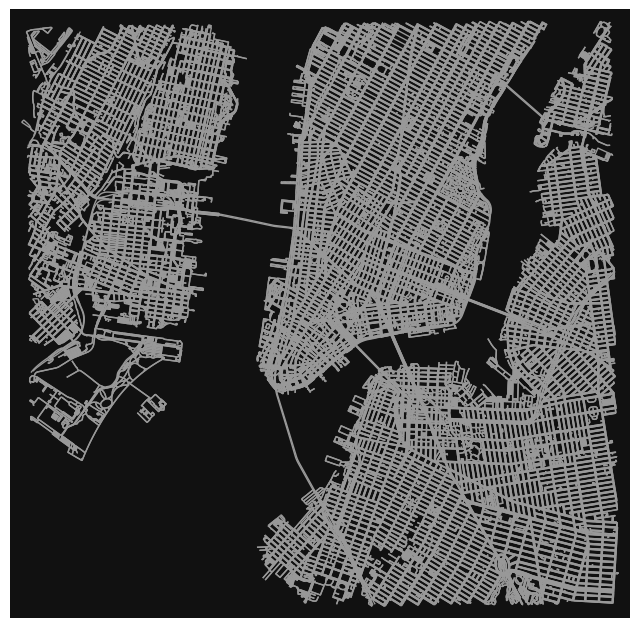

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [478]:
graph = ox.graph_from_address("NYC, NY", dist=5000)
NYC_graph = ox.project_graph(graph)
ox.plot_graph(NYC_graph, node_size=0)

In [415]:
airport = gpd.read_file("./Final_Data/2/Airport Point.geojson")
NYC_Neighborhood = pd.read_csv("./Final_Data/1/2020 Neighborhood.csv")
NYC_Neighborhood['geometry'] = gpd.GeoSeries.from_wkt(NYC_Neighborhood['the_geom'])
NYC_Neighborhood = gpd.GeoDataFrame(NYC_Neighborhood, geometry='geometry').set_crs(epsg=4326)

# Spatial Join
art_geo = gpd.sjoin(
    NYC_art_1,  
    NYC_Neighborhood.to_crs(NYC_art_1.crs),  
    predicate="within",
    how="left",
)


NYC_art_manhattan = art_geo.loc[art_geo['BoroName'] == 'Manhattan']
NYC_museums_manhattan = NYC_art_manhattan.loc[NYC_art_manhattan['Type'] == 'Museums']

In [427]:
manhattan = NYC_Neighborhood.loc[NYC_Neighborhood['BoroName'] == 'Manhattan']
manhattan = manhattan.dissolve()
manhattan_outline = manhattan.squeeze().geometry

In [436]:
jfk = airport.loc[airport['name'] == 'John F. Kennedy International Airport']

In [387]:
import networkx as nx
from shapely.geometry import Point, box

In [ ]:
graph = manhattan
orig_node = NYC_museums_manhattan[] shortest node
airport_node = jfk[] nearest node 

In [472]:
NYC_museums_manhattan = NYC_museums_manhattan[NYC_museums_manhattan.within(manhattan.geometry.iloc[0])]

In [ ]:
NYC_museums_manhattan = NYC_museums_manhattan[['Name', 'Address', 'geometry']]

NYC_museums_manhattan = NYC_museums_manhattan.loc[NYC_museums_manhattan['Name'] != 'Ellis Island Museum']
NYC_museums_manhattan = NYC_museums_manhattan.loc[NYC_museums_manhattan['Name'] != 'American Immigration History Center']

In [489]:
def calculate_distance(row):
    destination_point = row['geometry']

    # Find the nearest nodes on the graph for the airport and destination points
    orig_node = ox.distance.nearest_nodes(graph, jfk.geometry.x, jfk.geometry.y)
    destination_node = ox.distance.nearest_nodes(graph, destination_point.x, destination_point.y)

    # Initialize airport_node for each row
    airport_node = ox.distance.nearest_nodes(graph, jfk.geometry.x, jfk.geometry.y)

    # Initialize variable
    shortest_travel_time = None

    # Check if there is a path before calculating
    if nx.has_path(graph, airport_node, destination_node):
        shortest_travel_time = nx.shortest_path_length(graph, airport_node, destination_node, weight='travel_time')

    return shortest_travel_time

# Assuming jfk is the airport information for the first row
jfk = NYC_museums_manhattan.iloc[0]

# Apply the function to calculate shortest travel time for each row
NYC_museums_manhattan['shortest_travel_time'] = NYC_museums_manhattan.apply(calculate_distance, axis=1)


In [491]:
NYC_museums_manhattan

Name  \
0              Alexander Hamilton U.S. Custom House   
2              American Academy of Arts and Letters   
3                          American Folk Art Museum   
5                American Museum of Natural History   
6                       American Numismatic Society   
..                                              ...   
125  American Sephardi Federation / Sephardic House   
126              YIVO Institute for Jewish Research   
127              American Jewish Historical Society   
128                       Yeshiva University Museum   
129                       Center For Jewish History   

                              Address                    geometry  \
0                       1 Bowling Grn  POINT (-74.01376 40.70382)   
2                    633 W. 155th St.  POINT (-73.94730 40.83385)   
3                 45 West 53rd Street  POINT (-73.97810 40.76162)   
5    Central Park West at 79th Street  POINT (-73.97365 40.78083)   
6                        75 Varick St  POINT (-74.00701 40.72353)   
..                                ...                         ...   
125                    15 W. 16th St.  POINT (-73.99389 40.73808)   
126                    15 W. 16th St.  POINT (-73.99379 40.73796)   
127                    15 W. 16th St.  POINT (-73.99393 40.73802)   
128                    15 W. 16th St.  POINT (-73.99382 40.73805)   
129                    15 W. 16th St.  POINT (-73.99387 40.73799)   

     shortest_travel_time  
0                       0  
2                     103  
3                      61  
5                      57  
6                      72  
..                    ...  
125                    75  
126                    75  
127                    75  
128                    75  
129                    75  

[85 rows x 4 columns]